<a href="https://colab.research.google.com/github/Boboev/-/blob/master/Sign_Language_Digits_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Цель проекта заключается в том, чтобы классифицировать цифры, которые показаны на картинках языком жестов.



План дейстивий:

- Используем нейросетевою модель vgg13

- Предобучаем модель

- Аугментации

- Тест тайм аугментации

Здесь мы импортируем необходимые модули, которые нам понадобятся.Это стандартные модули PyTorch, которые используются регулярно.

In [2]:
import pickle
import numpy as np
# from skimage import io
import torch
import os
import cv2

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from IPython.display import clear_output

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [1]:
IMG_SIZE = 100


# Загрузка и подготовка набора данных
В этом разделе мы определим все операции предварительной обработки изображений. Вместе с этим мы загрузим данные  и преобразуем их.

In [ ]:
TRAIN_DIR = Path('../input/sldc/train/train')
TEST_DIR = Path('../input/sldc/test/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.JPG')))
test_files = sorted(list(TEST_DIR.rglob('*.JPG')))

In [ ]:
len(test_files)

105

In [ ]:
np.random.seed(5)
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [ ]:
class XDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.len_ = len(self.files)     
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((IMG_SIZE, IMG_SIZE))
        return np.array(image)

In [ ]:
test_dataset = XDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)

train_dataset = XDataset(train_files, mode="train")
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=16)

val_dataset = XDataset(val_files, mode="val")
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=16)

Проверяем доступности CUDA

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Загружем модел VGG13

In [ ]:
vgg = models.vgg13(pretrained=True)
vgg.to(device)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16):

#Замораживание часть веса свертки
Здесь важно отметить, что модель классификатора классифицирует 1000 классов. Но нам нужно классифицировать изображения только на 10 классов.  Кроме того, мы заморозим не все веса сверточных блоков.  

Следующий блок кода вносит необходимые изменения для классификации 10 классов вместе с замораживанием весов.

In [ ]:
#изменение количества классов
vgg.classifier[6].out_features = 10
# замораживание часть веса свертки 
linear = nn.Linear(1,1)

for param in linear.parameters():
    param.requires_grad = False

with torch.no_grad():
    linear.eval()
    print(linear.weight.requires_grad)


False


#Оптимизатор и функция потерь
Мы будем использовать оптимизатор CrossEntropyLoss(), который в большинстве случаев работает довольно хорошо. 

In [ ]:
#оптимизатор
optimizer = optim.Adam(vgg.classifier.parameters(), lr=0.0003) 
#функция потерь
criterion = nn.CrossEntropyLoss()

#Функции обучения и валидации
Мы напишем здесь два разных метода. Один предназначен для проверки, а другой-для обучения. 
В этом val() методе мы рассчитываем потери и точность. Но мы не возвращаемся к градиентам. Обратное распространение требуется только во время обучения.

In [ ]:
#функция для проверки,вычисляем потери и точность.
def val(model, val_loader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(val_loader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(val_loader.dataset)
    val_accuracy = 100. * val_running_correct/len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')
    
    return val_loss, val_accuracy

Далее мы определим tr() методику обучения. 
В строке 14 tr() метода мы вычисляем градиенты и обратное распространение.

Мы будем обучать и проверять модель в течение 50 эпох. Все это время, оба метода tr(), и val() будет продолжать возвращать потери и значения точности для каждой эпохи.

Давайте потренируем модель на 50 эпох. Для каждой эпохи мы будем называть метод tr() и.val()

In [ ]:
# функция обучения
def tr(model, train_loader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_loader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_loader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [ ]:
#потренируем модель на 50 эпох
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
for epoch in range(50):
    print("Epoch:", epoch + 1)
    train_epoch_loss, train_epoch_accuracy = tr(vgg, train_loader)
    val_epoch_loss, val_epoch_accuracy = val(vgg, val_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Epoch: 1
Train Loss: 0.4358, Train Acc: 38.51
Validation Loss: 1.6576, Validation Acc: 9.93
Epoch: 2
Train Loss: 0.2973, Train Acc: 44.15
Validation Loss: 1.0518, Validation Acc: 9.93
Epoch: 3
Train Loss: 0.1773, Train Acc: 61.37
Validation Loss: 0.7272, Validation Acc: 19.85
Epoch: 4
Train Loss: 0.1266, Train Acc: 64.40
Validation Loss: 0.5851, Validation Acc: 21.07
Epoch: 5
Train Loss: 0.1031, Train Acc: 65.55
Validation Loss: 0.6948, Validation Acc: 19.85
Epoch: 6
Train Loss: 0.0948, Train Acc: 66.34
Validation Loss: 0.8620, Validation Acc: 22.28
Epoch: 7
Train Loss: 0.0937, Train Acc: 71.56
Validation Loss: 0.6575, Validation Acc: 19.85
Epoch: 8
Train Loss: 0.1130, Train Acc: 71.32
Validation Loss: 0.4781, Validation Acc: 21.07
Epoch: 9
Train Loss: 0.0840, Train Acc: 72.16
Validation Loss: 0.2451, Validation Acc: 30.51
Epoch: 10
Train Loss: 0.0820, Train Acc: 69.56
Validation Loss: 0.3689, Validation Acc: 29.78
Epoch: 11
Train Loss: 0.0529, Train Acc: 75.56
Validation Loss: 0.3118,

После каждой эпохи мы сохраняем значения точности обучения и потерь в train_accuracy, train_loss и val_accuracy,val_loss. Мы видим, что к концу тренировки точность нашей тренировки составляет 81.50%.


#Визуализация графиков
Теперь давайте визуализируем графики точности и потерь для лучшего прояснения.

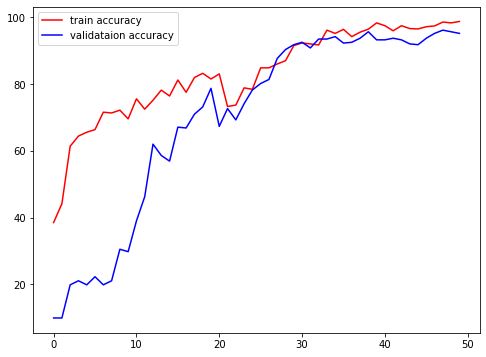

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, color='red', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

К концу обучения точность обучения превышает точность валидации. В частности, мы получаем около 81.50% обучения и 78.69% точности проверки.

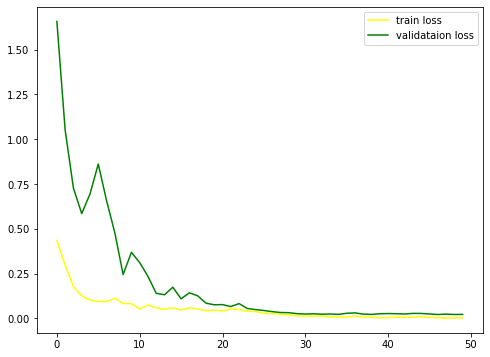

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, color='yellow', label='train loss')
plt.plot(val_loss, color='green', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

График потерь при обучении и валидации

In [ ]:
def test(model, test_loader):
    predictions = []
    for int, data in enumerate(test_loader):
        data = data.to(device)
        print(data.shape)
        output = model(data)
        _, preds = torch.max(output.data, 1)
        predictions.extend(preds)
    return predictions

In [ ]:
p = test(vgg, test_loader)

torch.Size([16, 3, 100, 100])
torch.Size([16, 3, 100, 100])
torch.Size([16, 3, 100, 100])
torch.Size([16, 3, 100, 100])
torch.Size([16, 3, 100, 100])
torch.Size([16, 3, 100, 100])
torch.Size([9, 3, 100, 100])


In [ ]:
out = []
for val in p:
    val = val.cpu().numpy()
    out.append(int(val))

In [ ]:
print(out)
test_labels = [0, 0, 1, 9, 9, 9, 9, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 3, 3, 3, 3, 4, 
               4, 4, 4, 4, 5, 0, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 0, 7, 7, 7, 7, 7, 8, 
               8, 8, 8, 8, 0, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 
               2, 2, 2, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 5, 5, 5, 5, 6, 6, 6, 6, 
               6, 7, 0, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9]

[0, 0, 1, 9, 9, 9, 9, 0, 1, 1, 1, 1, 1, 1, 1, 6, 6, 0, 3, 3, 3, 3, 4, 4, 4, 6, 4, 5, 0, 5, 5, 5, 5, 6, 6, 4, 6, 4, 4, 0, 4, 4, 4, 4, 7, 9, 4, 8, 8, 4, 0, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 6, 6, 0, 3, 5, 9, 3, 3, 4, 6, 4, 4, 4, 0, 5, 5, 5, 9, 4, 6, 6, 6, 6, 4, 0, 4, 9, 4, 6, 8, 8, 9, 8, 8, 9]


In [ ]:
cnt = 0
for i in range(len(out)):
    if out[i] == test_labels[i]:
        cnt += 1

print(cnt)

76


In [ ]:
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['id'] = test_filenames
df['labels'] = out
df.to_csv('predictions.csv', index=False)

In [ ]:
df

,id,labels
0,img0.JPG,0
1,img1.JPG,0
2,img10.JPG,1
3,img100.JPG,9
4,img101.JPG,9
...,...,...
100,img95.JPG,8
101,img96.JPG,9
102,img97.JPG,8
103,img98.JPG,8


#Заключение
Мы получаем довольно хорошие результаты, но можем добиться еще большего. Мы настроили и смоделировали значения VGG13 и получили еще большую точность.  Начали заморозить некоторые слои и обучить некоторые другие. 